In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

from sklearn import linear_model

In [3]:
sns.set_palette("deep")

In [4]:
DATA = './data/'

# Exercise 1: Propensity Score Matching

### Clarification:


- A column is added to the lalonde dataframe representing minorities, whereby black and hispanic subjects are included.


- If a subject has a '0' as covariate 're74', 're75' or 're78', the subject is assumed to not have had ANY income in that specific year as specified on Mattermost.


- An additional binary column is added, whose entry is True, if the subject had no real income in 1974 or 1975. 


- The columns 'minority' and 'zero_in_74/75' were added in order to get better results from the linear regression.


In [5]:
lalonde = pd.read_csv(DATA + 'lalonde.csv', index_col=0)

lalonde['minority'] = lalonde['black'] + lalonde['hispan']
lalonde['zero_in_74/75'] = ((lalonde.re74 == 0 ) | (lalonde.re75 == 0))
lalonde.head()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,minority,zero_in_74/75
id,,,,,,,,,,,,
NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460,1,True
NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940,1,True
NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500,1,True
NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460,1,True
NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899,1,True


### 1.1 A naive analysis

In this first naive analysis we seperate the data into two groups, where the first group received treatment and the second group did not receive treatment. We compare these groups solely by the real earnings of the subjects in 1978. 


In [6]:
treated = lalonde[(lalonde.treat == 1)]
non_treated = lalonde[(lalonde.treat == 0)]

#### A look at some numbers:


Total subjects: 		614
Number of treated subjects: 	185
Number of control subjects: 	429
Mean income treatment group: 	6349.14
Mean income control group: 	6984.17


[(-1000, 65000), <matplotlib.text.Text at 0x115f87048>]

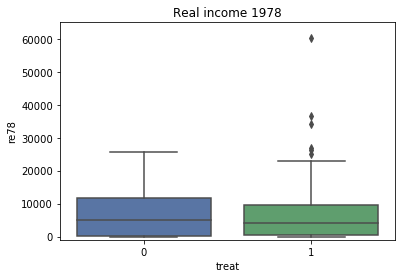

In [7]:
print('Total subjects: ' + '\t' + '\t' +str(len(lalonde)))
print('Number of treated subjects: '+ '\t' + str(len(treated)))
print('Number of control subjects: '+ '\t' + str(len(non_treated)))
print('Mean income treatment group: ' + '\t' +str(round(treated.re78.mean(),2)))
print('Mean income control group: ' +'\t' + str(round(non_treated.re78.mean(),2)))

sns.boxplot(x = 'treat', y='re78', data = lalonde).set(ylim= (-1000,65000),title="Real income 1978")

From the total number of subjects in the experiment only roughly a third received treatment. The mean of the income of the control group after treatment is higher than the mean income of treated subjects. This might lead one to believe, that the treatment was useless. The real income in 1978 is plotted using barplots above. The median of the control and treatment groups are roughly the same, note that there are a few individuals, that received treatment, which had significantly more real income in 1978, than the average. These individuals are shown in the above plot by the small diamonds.


#### A look at the distributions:

Below the distributions of the income of the treated and untreated subjects are plotted for the year 1978. The smoothed histograms look quite similar, both being heavily right skewed. In the plot representing the subjects, that received treatment the heavy outliers are visible.

[(0, 70000)]

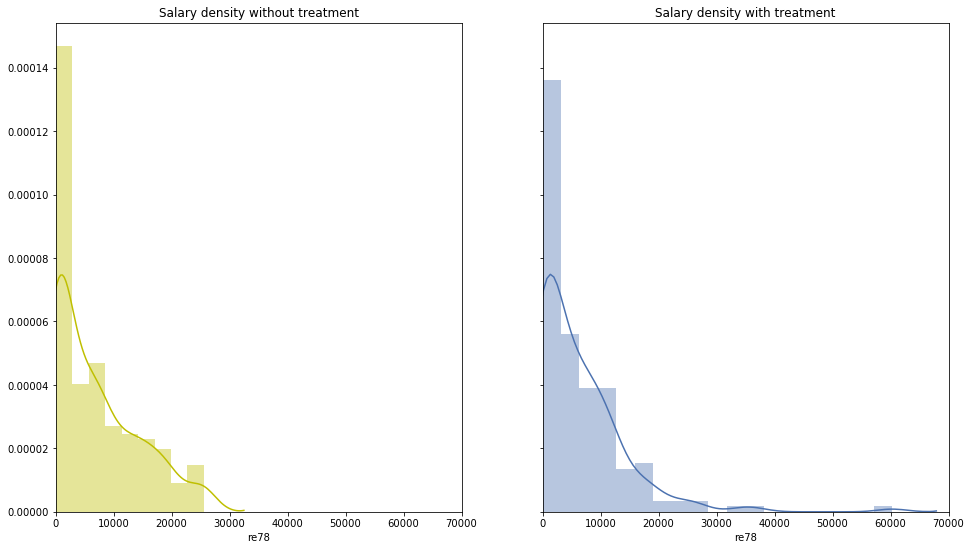

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(16, 9), sharey= True, sharex= True)

axs[0].set_title("Salary density without treatment")
sns.distplot(non_treated.re78, norm_hist=True, kde=True, ax=axs[0], color='y',label ='Not treated')

axs[1].set_title("Salary density with treatment")
sns.distplot(treated.re78, norm_hist=True, kde=True, ax=axs[1]).set(xlim=(0, 70000))

### 1.2 A closer look at the data

First we take a look at the covariates related to race. From the first and second plot it becomes clear, that an overwhelming majority of treated subjects are black. Hispanic subjects are less represented in both groups, but there are more in percentage in the control group, than in the treatment group.

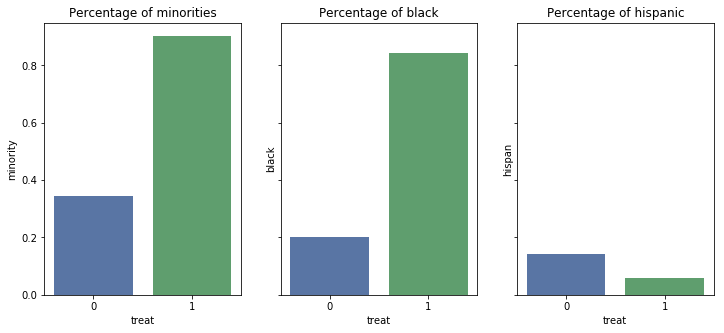

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(12, 5),sharey = True)

sns.barplot(x='treat', y='minority', data=lalonde, ax=axs[0], ci=None).set_title('Percentage of minorities')
sns.barplot(x='treat', y='black', data=lalonde, ax=axs[1], ci=None).set_title('Percentage of black')
sns.barplot(x='treat', y='hispan', data=lalonde, ax=axs[2], ci=None).set_title('Percentage of hispanic')

Now let's take a look at the other three covariates, which have binary entries. First of all more than two thirds of the treatment group did not have any real earnings in either the year 1974 or 1975. In the control group this was only the case for less than half of the subjects. 


Half of the subjects in the control group are married, where this is only the case for less than a fifth of the treatment group. In addition two thirds of the treatment group do not have a degree, whereby it is notable, that subjects from the control group also do not have a degree six out of ten times.

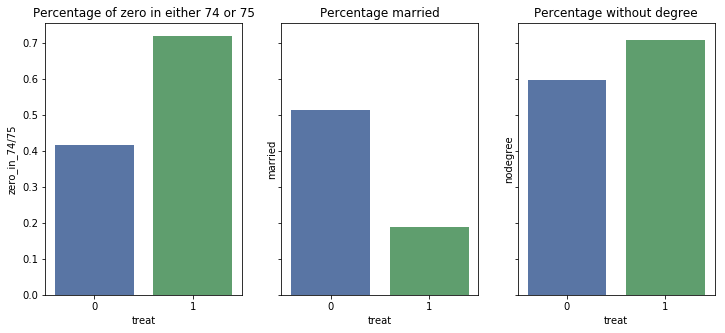

In [10]:
fig, axs = plt.subplots(1, 3, figsize=(12, 5),sharey = True)

sns.barplot(x='treat', y='zero_in_74/75', data=lalonde, ax=axs[0], ci=None).set_title('Percentage of zero in either 74 or 75')
sns.barplot(x='treat', y='married', data=lalonde, ax=axs[1], ci=None).set_title('Percentage married')
sns.barplot(x='treat', y='nodegree', data=lalonde, ax=axs[2], ci=None).set_title('Percentage without degree')

Clearly the treated subjects were not chosen randomly. They are overwhelmingly composed of unmarried black people, whereby two thirds do not have a degree and did not have any real earnings in either 1974 or 1975. Around half of the control group are married and have degrees and only about a third are minorities.

Next we look at the mean of the age, the average number of years in education and the mean income in 1975 and 1974. We chose to represent these covariates using violinplots. 

[(-10000, 40000), <matplotlib.text.Text at 0x116eaacc0>]

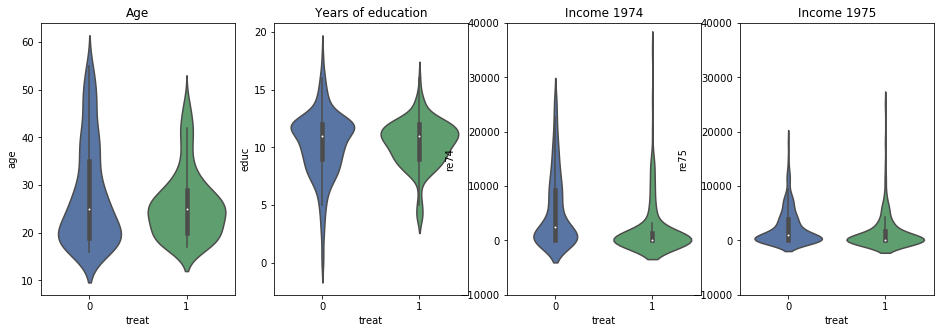

In [11]:
fig, axs = plt.subplots(1, 4, figsize=(16, 5))

sns.violinplot(x = 'treat',y ='age', data = lalonde,ax = axs[0]).set_title('Age')
sns.violinplot(x = 'treat',y ='educ', data = lalonde,ax = axs[1]).set_title('Years of education')
sns.violinplot(x = 'treat',y ='re74', data = lalonde,ax = axs[2]).set(ylim=(-10000, 40000),title='Income 1974')
sns.violinplot(x = 'treat',y ='re75', data = lalonde,ax = axs[3]).set(ylim=(-10000, 40000),title='Income 1975')

Additionally to the above stated differences between the features of the treated subjects and those of the control group, it is now visible, that the treated subjects are between twenty and thirty years old on average and almost all had no income in the year 1974. The age distribution of the control group is distributed much more evenly between twenty and fifty years, whereby the bulk is also in the early twenties. 


In 1975 the control group and the treatment group both have significantly less real earnings, which seems a bit fishy. The average years of education between the two groups is about the same, which is not surprising, because highschool takes twelve years, whereby many of the treatment subjects dropped out of highschool between their ninth and eleventh year of education.


### Impact on the conclusions of the naive research:

Naively looking at the outcome of the experiment implies that the treatment was probably a failure. Looking at the data more carefully, we find out:


- The control group is twice as large as the treatment group.


- The treatment group is overwhelmingly comprised of unmarried minorities with no income in 1974 and 1975, a bit more than half of which finished highschool, and are on average in their mid twenties.


- The control group is far more diverse.


In order to compare the two groups a propensity score model is applied.


### 1.3 A propensity score model

To find the propensity score a linear regression is applied, whereby the 'treated' and the 're78' covariates are dropped and the propensity score is added to the dataframe as an additional covariate. The propensity score gives the probablity of being assigned to the treated group, given a feature vector.

In [12]:
logistic = linear_model.LogisticRegression()

X = lalonde.drop(['treat','re78'],axis=1)
y = lalonde['treat']

model = logistic.fit(X,y)

lalonde['propensity']= model.predict_proba(X)[:,1]
treated = lalonde[(lalonde.treat == 1)]
non_treated = lalonde[(lalonde.treat == 0)]

lalonde.head()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,minority,zero_in_74/75,propensity
id,,,,,,,,,,,,,
NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460,1,True,0.448327
NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940,1,True,0.227808
NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500,1,True,0.730015
NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460,1,True,0.664335
NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899,1,True,0.704908


### 1.4 Balancing the dataset via matching

Now for every subject in the treatment group we find a match in the control group. This is done using the networkx library. 

- We loop over all treated and control subjects.


- We create an edge between the subjects whereby the weight is minus the absolute value of the difference between the propensity scores.


- Doing this we have created a fully connected bipartite graph.


- To find the matches the max_weight_matching function from the networkx library is applied, which finds the match for every subject minimizing the sum of the weights. (It minimizes, because the negative absolute difference was chosen, while creating the fully connected bipartite graph.)


- The resulting dictionary gets searched for the values assigned to the keys, which start with 'NSW'. This returns the list of control group subjects, that was matched to the treatment group.


- A new dataframe non_treated_match is created containing the 185 subjects of the control group, that were matched.


- A dataframe is created containing the matched control and treatment group, appending one to the other.

In [13]:
G = nx.Graph()

for index_t, t in treated.iterrows():
    for index_n, n in non_treated.iterrows():
        w = -np.abs(t.propensity-n.propensity)
        G.add_edge(index_t, index_n, weight=w)

match = nx.max_weight_matching(G,True)

In [14]:
psids = [v for k, v in match.items() if 'NSW' in k]
non_treated_match = non_treated.loc[psids]

matched_experiment = treated.append(non_treated_match)
matched_experiment.head()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,minority,zero_in_74/75,propensity
id,,,,,,,,,,,,,
NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460,1,True,0.448327
NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940,1,True,0.227808
NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500,1,True,0.730015
NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460,1,True,0.664335
NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899,1,True,0.704908


#### Comparing the outcome of the experiment looking at matched subjets


First the mean real earnings of the matched subjects is shown:

Mean income treatment group: 	6349.14
Mean income control group: 	5617.21


[(-1000, 65000), <matplotlib.text.Text at 0x1178889b0>]

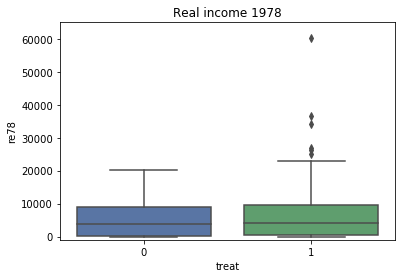

In [15]:
print('Mean income treatment group: ' + '\t' +str(round(matched_experiment[matched_experiment.treat == 1].re78.mean(),2)))
print('Mean income control group: ' +'\t' + str(round(matched_experiment[matched_experiment.treat == 0].re78.mean(),2)))
sns.boxplot(x = 'treat', y='re78', data = matched_experiment).set(ylim= (-1000,65000),title="Real income 1978")

Alas, it looks like the treatment was a success, after subjects with similar covariates were matched! The mean real earnings of the matched control subjects is lower, than the mean real earnings of the treatment group. Looking at the boxplots it is less obvious, if the treatment was a success. The medians are very close to each other. The larger mean could simply come from the outliers, which are present, knowing that the mean is an unstable statistic.


To be sure, that our method of matching was reasonable, let's take a look at the features of the matched subjects.


First the age, number of years of education and the income in 1974 and 1975 are compared, whereby as above violinplots are chosen:

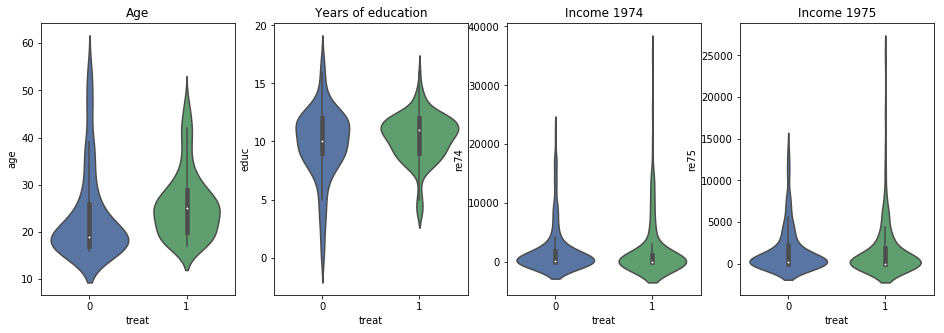

In [16]:
fig, axs = plt.subplots(1, 4, figsize=(16, 5))

sns.violinplot(x = 'treat',y ='age', data = matched_experiment,ax = axs[0]).set_title('Age')
sns.violinplot(x = 'treat',y ='educ', data = matched_experiment,ax = axs[1]).set_title('Years of education')
sns.violinplot(x = 'treat',y ='re74', data = matched_experiment,ax = axs[2]).set_title('Income 1974')
sns.violinplot(x = 'treat',y ='re75', data = matched_experiment,ax = axs[3]).set_title('Income 1975')

The income in 1974, which was heavily unbalanced before seems to have been corrected reasonably well. Through matching the mean age of the control group fell drastically, whereby the median is below twenty now. The years of education of the matched control group also dropped to a median of ten years, but the violinplots still look rather comparable.

Next the covariates, 'zero_in_74/75', 'married' and 'nodegree' are inspected for the matched subjects:

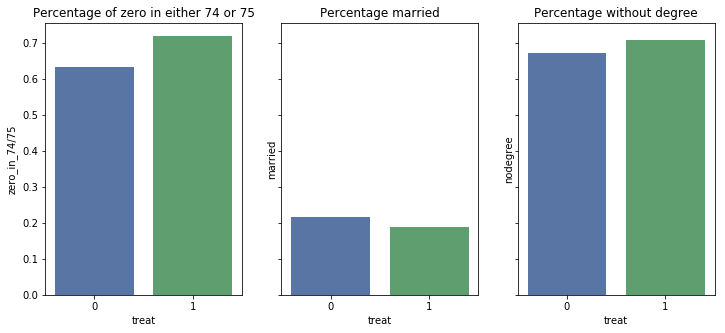

In [17]:
fig, axs = plt.subplots(1, 3, figsize=(12, 5),sharey = True)

sns.barplot(x='treat', y='zero_in_74/75', data=matched_experiment, ax=axs[0], ci=None).set_title('Percentage of zero in either 74 or 75')
sns.barplot(x='treat', y='married', data=matched_experiment, ax=axs[1], ci=None).set_title('Percentage married')
sns.barplot(x='treat', y='nodegree', data=matched_experiment, ax=axs[2], ci=None).set_title('Percentage without degree')

These covariates are balanced well. The subjects in control and treatment groups are largely unmarried, and two thrids have no degree and no real earnings in either 1974 or 1975.

Now let us inspect the covariates related to race:

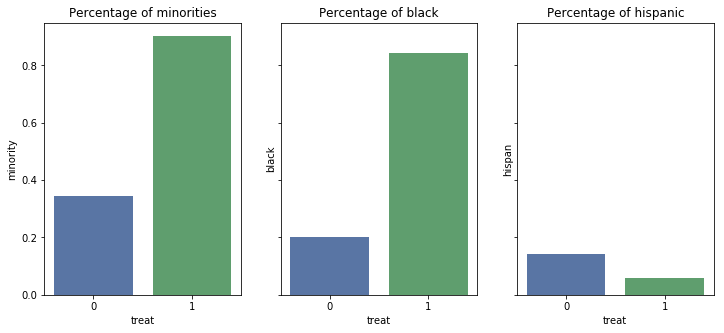

In [18]:
fig, axs = plt.subplots(1, 3, figsize=(12, 5),sharey = True)

sns.barplot(x='treat', y='minority', data=lalonde, ax=axs[0], ci=None).set_title('Percentage of minorities')
sns.barplot(x='treat', y='black', data=lalonde, ax=axs[1], ci=None).set_title('Percentage of black')
sns.barplot(x='treat', y='hispan', data=lalonde, ax=axs[2], ci=None).set_title('Percentage of hispanic')

For these covariates the matching has clearly failed. Still only a third of the control group is black. This needs to be corrected.


Further, knowing that every subject of the treatment group was matched, let us inspect the difference of the propensity scores of the matched subjects. 


Were similar subjects matched?


- A column is added to the dataframe containing the id of the matched subject. This is done by accessing the id and then using the above created dictionary, to map the matched id, which is the value of the dictionary, to the current id.


- Next the propensity score of the matched subject is added to the dataframe. This is done by locating the id of the matched subject, then getting the propensity score from this row and saving it in the new column. 


- A column named prop_diff is added containing the absolute difference of the propensity scores of the matched subjects.


- To further facilitate this finer grained matching a binary column is added containing a true value, if a black subject was matched to a white or hispanic subject. This is done by comparing the entry of the 'black' covariate with the entry of the 'black' covariate of the matched subject.

In [19]:
matched_experiment['matched'] = matched_experiment.index.to_series().map(match)

matched_experiment['matched_prop'] = matched_experiment.loc[matched_experiment.matched].propensity.values

matched_experiment['prop_diff'] = np.abs(matched_experiment.propensity-matched_experiment.matched_prop)

matched_experiment['black_to_white'] = (matched_experiment.black.values != matched_experiment.
                                        loc[matched_experiment.matched].black.values)

matched_experiment.head()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,minority,zero_in_74/75,propensity,matched,matched_prop,prop_diff,black_to_white
id,,,,,,,,,,,,,,,,,
NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460,1,True,0.448327,PSID151,0.138704,0.309624,True
NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940,1,True,0.227808,PSID339,0.201671,0.026137,False
NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500,1,True,0.730015,PSID372,0.729635,0.000380,False
NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460,1,True,0.664335,PSID316,0.129939,0.534396,True
NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899,1,True,0.704908,PSID278,0.701853,0.003055,False


### 1.5 Balancing the groups further:

As mentioned above, the matching done before is not bad, but can clearly be improved. Let us first inspect how many matches were done poorly with respect to the propensity score and how many times a black subject was matched to a white subject:


In [20]:
print('Of the ' +  str(len(matched_experiment)/2) + ' matched couples ' + 
      str(len(matched_experiment.prop_diff[matched_experiment.prop_diff >= 0.5])/2) +
      ' were matched poorly (prop_diff >= 0.5).')

print('Of the ' + str(len(matched_experiment)/2) + ' matched couples ' + 
     str(len(matched_experiment.black_to_white[matched_experiment.black_to_white == True])/2) +
     ' are matches between a black and a white subject.')

Of the 185.0 matched couples 38.0 were matched poorly (prop_diff >= 0.5).
Of the 185.0 matched couples 69.0 are matches between a black and a white subject.


The way we improve our matching is by excluding matches that were matched poorly **and** where a black subject is matched to a white subject. The difference in propensity score before and after the second matching is shown below. It is clear, that the second matching has greatly improved the matching.

Applying this rule to our dataframe leaves us with 185.0 matched couples.


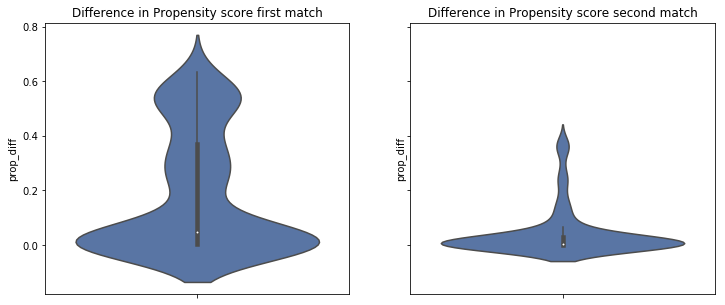

In [21]:
better_match = matched_experiment[(matched_experiment.prop_diff <= 0.5) & (matched_experiment.black_to_white == False)]
print('Applying this rule to our dataframe leaves us with ' + str(len(matched_experiment)/2) + ' matched couples.')

fig, axs = plt.subplots(1, 2, figsize=(12, 5),sharey = True)

sns.violinplot(y =matched_experiment.prop_diff,ax = axs[0]).set_title('Difference in Propensity score first match')
sns.violinplot(y =better_match.prop_diff,ax = axs[1]).set_title('Difference in Propensity score second match')

#### Inspecting the second match

Looking at the covariates of subject after the second round of matching, we can observe that the additional constraints of not allowing black subjects match to white subjects and the difference of the propensity score having to be less than 0.5 gives us two well balanced groups.


First we look at the covariates age, years of education and income in 1974 and 1975, whereby as above violinplots are chosen:

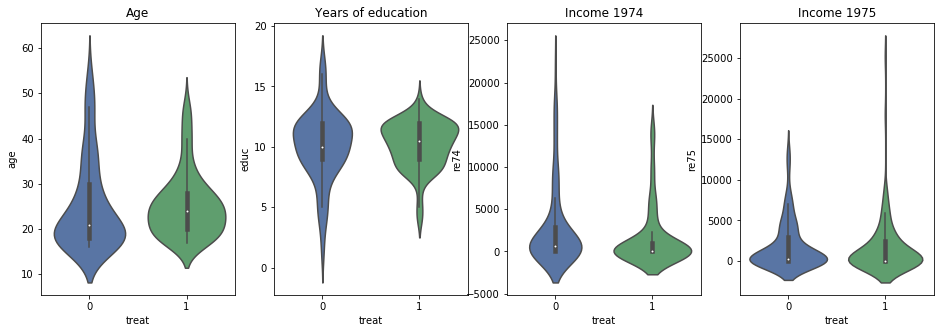

In [22]:
fig, axs = plt.subplots(1, 4, figsize=(16, 5))

sns.violinplot(x = 'treat',y ='age', data = better_match,ax = axs[0]).set_title('Age')
sns.violinplot(x = 'treat',y ='educ', data = better_match,ax = axs[1]).set_title('Years of education')
sns.violinplot(x = 'treat',y ='re74', data = better_match,ax = axs[2]).set_title('Income 1974')
sns.violinplot(x = 'treat',y ='re75', data = better_match,ax = axs[3]).set_title('Income 1975')

The age, years of education and real earnings in 1974 and 1975 are reasonably well balanced.


Let's look at the covariates married, the number of subjects that had no real earnings in either 1974 or 1975 and teh percentage of subjects without a degree:

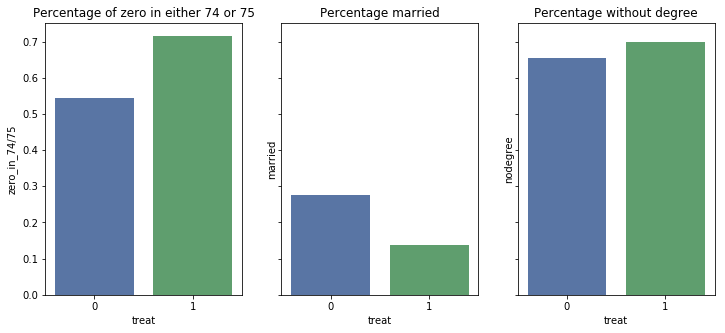

In [23]:
fig, axs = plt.subplots(1, 3, figsize=(12, 5),sharey = True)

sns.barplot(x='treat', y='zero_in_74/75', data=better_match, ax=axs[0], ci=None).set_title('Percentage of zero in either 74 or 75')
sns.barplot(x='treat', y='married', data=better_match, ax=axs[1], ci=None).set_title('Percentage married')
sns.barplot(x='treat', y='nodegree', data=better_match, ax=axs[2], ci=None).set_title('Percentage without degree')

Around the same percentage of subjects have no degree and the percentage of married subjects is also more similar, than before matching. 


15 percent less subjects of the control group had no real earnings in either 1974 or 1975, this is substantial, but we need to keep in mind, that the second match was done with the constraints on the difference of the propensity score and on if black people were matched to white people.


Now let us look at the covariates related to race:

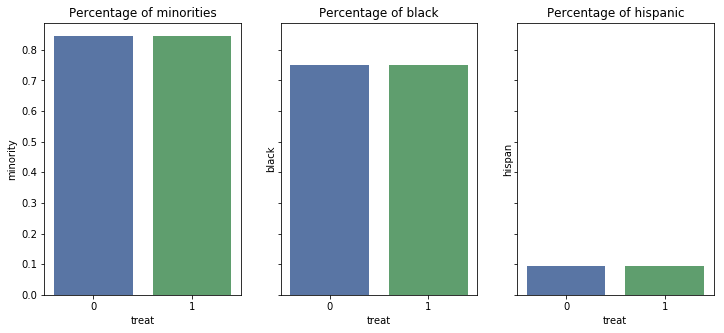

In [24]:
fig, axs = plt.subplots(1, 3, figsize=(12, 5),sharey = True)

sns.barplot(x='treat', y='minority', data=better_match, ax=axs[0], ci=None).set_title('Percentage of minorities')
sns.barplot(x='treat', y='black', data=better_match, ax=axs[1], ci=None).set_title('Percentage of black')
sns.barplot(x='treat', y='hispan', data=better_match, ax=axs[2], ci=None).set_title('Percentage of hispanic')


Finally the covariates black, hispanic and minority are well balanced. We can proceed to the last part of the exercise, which is a less naive analysis.

### 1.6 A less naive analysis

Now that the treatment and control groups are well balanced we can do a less naive analysis. The subjects are largely minorities in their early twenties, that on average almost finished highschool, have mostly no income at the beginning of the experiment and are mostly unmarried.

Below are numbers and boxplots representing the real earnings of the matched groups in 1978:

In [25]:
print('Mean of real earnings 1978 of the treatment group after the second matching: ' +'\t' 
      +str(round(better_match[better_match.treat == 1].re78.mean(),2)))
print('Mean of real earnings 1978 of the control group after the second matching: ' +'\t' 
      +str(round(better_match[better_match.treat == 0].re78.mean(),2)))
print('Median of real earnings 1978 of the treatment group after the second matching: ' +'\t' 
      +str(round(better_match[better_match.treat == 1].re78.median(),2)))
print('Median of real earnings 1978 of the control group after the second matching: ' +'\t' 
      +str(round(better_match[better_match.treat == 0].re78.median(),2)))


Mean of real earnings 1978 of the treatment group after the second matching: 	6405.18
Mean of real earnings 1978 of the control group after the second matching: 	5158.06
Median of real earnings 1978 of the treatment group after the second matching: 	4402.27
Median of real earnings 1978 of the control group after the second matching: 	2600.06


[(-1000, 65000), <matplotlib.text.Text at 0x1188050b8>]

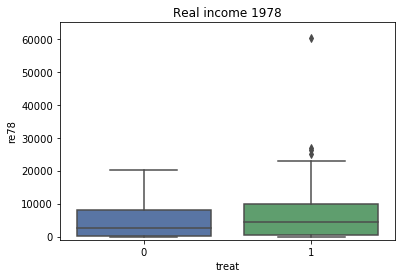

In [26]:
sns.boxplot(x = 'treat', y='re78', data = better_match).set(ylim= (-1000,65000),title="Real income 1978")

The expermiment was a success. After matching the subjects in a less naive way the mean of the real earnings of the treatment group is more than a thousand higher, than that of the control group. The difference in median of the real earnings in 1978 is even stronger, amounting to more than two thousand. The boxplots shown above underline these findings further showing, that there are less subjects in the treatment group, that still have no real earnings in 1978, than in the control group.

# Exercise 2: Applied ML

In [27]:
import itertools

from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split, cross_val_predict, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

## 2.1 Feature Preparation

To load the **20newsgroups** dataset, we use a built-in function in sklearn. **Warning:** If you do not already have this data set saved on your computer, it will automatically download it (Download size: ca 14MB)!

We then transform each of the 18'846 articles to a sparse vector of length 134'410. We compute this feature vector using the **TF-IDF** algorithm (TfidfVectorizer in sklearn).

In [28]:
newsgroups = fetch_20newsgroups(subset='all', 
                                shuffle=True,
                                remove=('headers', 'footers', 'quotes'))

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(newsgroups.data)
y = newsgroups.target

In the assignment, it is asked to split the data into 80% training data, 10% validation data and 10% testing data.
We decided to not throw away 10% of the data for validation purposes and instead use crossvalidation with 90% of the total data and leave 10% for the test data.

During training with **crossvalidation**, we train the classifier multiple (k-fold) times on a different subset of the data and then test the results on the validation data subset that we shift in each iteration. In the end, we average the results from all iterations and the classifier has been trained and tested on the whole training set. A more detailed explanation of crossvalidation can be found in the lecture notes.

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

## 2.2 Training a Random Forest

The 20 news groups will be learned using a random forest classifier from sklearn.

In [30]:
rf = RandomForestClassifier()

### Finding best hyper parameters using grid search

To find the best hyperparameters, we conduct a simple **grid search** over the number of random trees (*n_estimators*) and the maximum depth of the trees (*max_depth*). We decided to stop with *max_depth* 50 and *n_estimators* 100, since the running times start getting too high.

**Warning**: The gridsearch over all 100 combinations of those two parameters takes a very long time! (Around 2 hours on a MacBook Pro)

In [31]:
param_grid = {
    "n_estimators": [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    "max_depth":    [ 5, 10, 15, 20, 25, 30, 35, 40, 45,  50]
}

rf_grid = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, verbose=1)
rf_grid.fit(X_train, y_train)
print('Best hyper parameters:', rf_grid.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed: 100.9min finished


Best hyper parameters: {'n_estimators': 100, 'max_depth': 50}


### Plotting the grid search results

To evaluate how well the brute forced hyper parameters of the grid search are doing, we plot them in a grid and display their crossvalidation test accuracies:

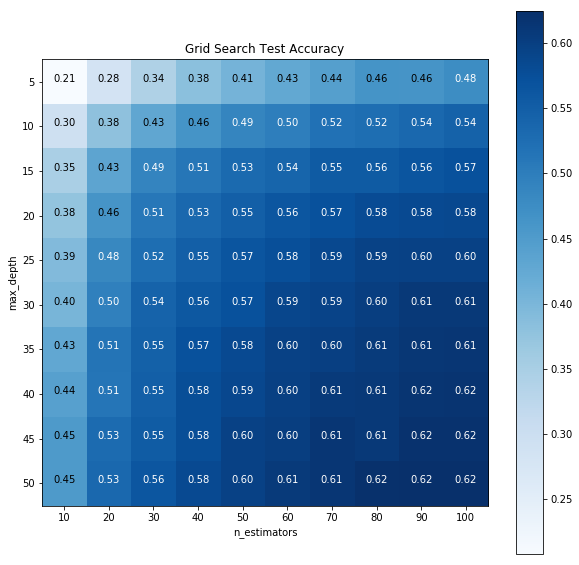

In [32]:
# Extract results from grid search
test_scores = rf_grid.cv_results_['mean_test_score']
test_scores = test_scores.reshape((len(param_grid['max_depth']), len(param_grid['n_estimators'])))
max_depth_idx = rf_grid.cv_results_['param_max_depth']
n_estimators_idx = rf_grid.cv_results_['param_n_estimators']

# Setting up grid plot
plt.figure(figsize=(10,10))
plt.imshow(test_scores, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Grid Search Test Accuracy')
plt.colorbar()
plt.xticks(np.arange(len(param_grid['n_estimators'])), param_grid['n_estimators'])
plt.yticks(np.arange(len(param_grid['max_depth'])), param_grid['max_depth'])

fmt = '.2f'
thresh = test_scores.max() * 3 / 4.

# Adding test error numbers to plot
for i, j in itertools.product(range(test_scores.shape[0]), range(test_scores.shape[1])):
    plt.text(j, i, format(test_scores[i,j], fmt),
            horizontalalignment="center",
            color="white" if test_scores[i,j] > thresh else "black")

plt.ylabel('max_depth')
plt.xlabel('n_estimators')

In this plot, we clearly see that the model continues improving the higher each of the two parameters get. However, for the max_depth, we start getting diminishing returns for the accuracy at around depth 25. Similarily for the number of estimators, we stop getting much better accuracies after around 50 estimators.

From the grid search, we can directly extract the trained best model:

In [33]:
best_rf = rf_grid.best_estimator_

To see if our model is good, we calculate various metrics using the test data that the algorithm has never seen. We propose the following metrics:

- Accuracy: The fraction of correctly labeled articles
- Precision: The fraction of positive predictions that are actually positive
- Recall: The fraction of positive examples that were recognized as positive
- F1: Harmonic mean of precision and recall

In [34]:
y_pred = cross_val_predict(best_rf, X_test, y_test, cv=5)
print('Evaluating quality of model with best parameters:\n')
print('Accuracy:\t', accuracy_score(y_test, y_pred))
print('Precision:\t', precision_score(y_test, y_pred, average='weighted'))
print('Recall:\t\t', recall_score(y_test, y_pred, average='weighted'))
print('F1:\t\t', f1_score(y_test, y_pred, average='weighted'))

Evaluating quality of model with best parameters:

Accuracy:	 0.529442970822
Precision:	 0.564417525926
Recall:		 0.529442970822
F1:		 0.523052536432


### Plotting the confusion matrix

In addition to the metrics above, another useful way to visually assess the quality of our predictions is a confusion matrix. In it, we plot a 2-dimensional histogram of the true labels of the test data against the predictions from our model.

In [35]:
cm = confusion_matrix(y_test, y_pred)

In [36]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    Adapted from: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


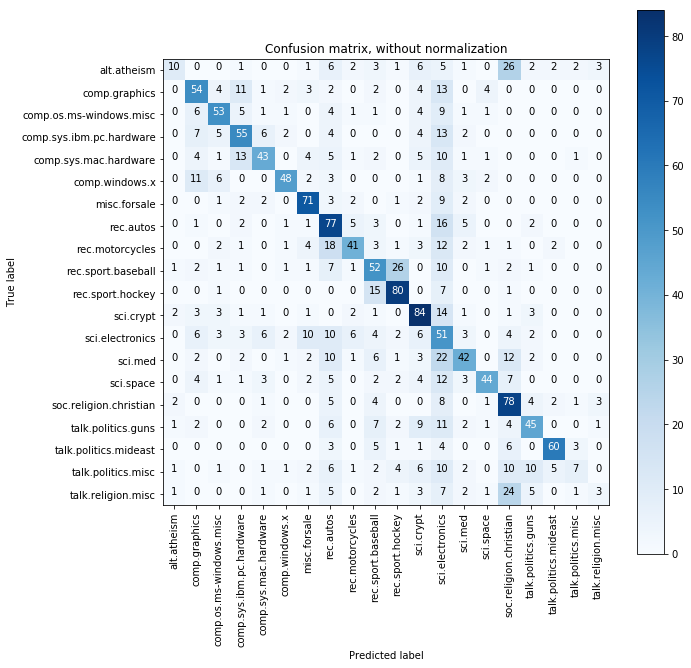

In [37]:
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=newsgroups.target_names,
                      title='Confusion matrix, without normalization')

We observe that most labels were correctly assigned, since the majority of entries in the confusion matrix lay on the diagonal. Many articles of all kinds of newsgroups were wrongly assigned to the category "rec:electronics". Also, articles of the categories "alt.atheism", "talk.politics.misc" and "talk.religion.misc" had troubles being assigned to the true labels and many of those articles were classified as "soc.religion.christian". An explanation might me that religion categories share some key feature words like "god" and "bible", so the model gets easily confused and missclassifies articles containing those words.

### Most important features

From the random forest with the best parameters, we extract the feature importances vector, where every element is the respective importance for the classification of each word. We then sort the words by the most important ones and display the first 100.

In [38]:
best_features_vec = best_rf.feature_importances_

feature_names = np.array(vectorizer.get_feature_names())
tfidf_sorting = np.argsort(best_features_vec).flatten()[::-1]

n = 100
top_n = feature_names[tfidf_sorting][:n]
top_n

array(['bike', 'car', 'sale', 'windows', 'game', 'hockey', 'israel',
       'shipping', 'clipper', 'god', 'apple', 'the', 'graphics', 'team',
       'key', 'space', 'of', 'gun', 'bible', 'baseball', 'motif', 'he',
       'nhl', 'that', 'to', 'christian', 'christ', 'jesus', 'chip', 'mac',
       'cars', 'for', 'christians', 'guns', 'offer', 'dos', 'ride', 'they',
       'church', 'keys', 'games', 'israeli', 'window', 'who', 'not', 'in',
       'is', 'and', 'arab', 'x11r5', 'escrow', 'thanks', 'condition', 'it',
       'jews', 'dod', 'card', 'drive', 'ide', 'government', 'season',
       'league', 'be', 'as', 'with', 'doctor', 'centris', 'by',
       'encryption', 'year', 'his', 'on', 'algorithm', 'server', 'was',
       'you', 'players', 'riding', 'armenian', 'can', 'people', 'sell',
       'nsa', 'have', 'this', 'secure', 'security', 'my', 'des', 'but',
       'xterm', 'catholic', 'program', 'we', 'use', 'or', 'serdar', 'an',
       'are', 'do'],
      dtype='<U81')

Printing the 100 most important features from the random forrest, we see some obvious and less intuitive results. Many words like "bike", "car", "sale", "windows" and "game" are very specific to a certain news category, so it makes sense that they are important for the random forest in deciding to which category an article belongs.

Other words like "the", "of", "he", "that" and "to" can be assumed to be common words in every kind of category, so it is slightly strange that they have such a strong classification power.